In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']

In [23]:
X = df.drop(columns=['Class'])
y = df['Class']
X_test = df_test.drop(columns=["Class"])
y_test = df_test["Class"]

df_test = pd.read_csv('../data/df_test.csv')

In [5]:
pd.set_option('display.float_format', '{:.4f}'.format)

# Basic models evaluation

In [31]:
def evaluate_model(models, X, y, X_test, y_test):
    results = []
    for model_name, model in models:
        if model_name == 'XGBoost':
            y = LabelEncoder().fit_transform(y)
            y_test = LabelEncoder().fit_transform(y_test)
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        results.append((model_name, accuracy, precision, recall))
    results = pd.DataFrame(results, columns=['Model Name', 'Accuracy', 'Precision', 'Recall'])
    results.sort_values('Accuracy', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)
    return results

In [35]:
models = [
    ('Dummy Classifier', DummyClassifier(strategy='most_frequent')),
    ('Decision Tree', DecisionTreeClassifier(random_state=311, max_depth=9, max_leaf_nodes=28, min_samples_leaf=2, criterion='log_loss')),
    ('SVC', SVC(kernel='linear', random_state=311)),
    ('Linear SVC', LinearSVC(random_state=311)),
    ('K Nearest Neighbors', KNeighborsClassifier(algorithm='auto', weights ='distance', n_neighbors=15, p=2)),
    ('Random Forest', RandomForestClassifier(random_state=311)),
    ('LGBM', LGBMClassifier(random_state=311)),
    ('XGBoost', XGBClassifier(random_state=311))
]

In [36]:
results = evaluate_model(models, X, y, X_test, y_test)
print(results)

            Model Name  Accuracy  Precision  Recall
0                 LGBM    0.9286     0.9289  0.9286
1              XGBoost    0.9286     0.9289  0.9286
2        Random Forest    0.9220     0.9222  0.9220
3                  SVC    0.9108     0.9114  0.9108
4        Decision Tree    0.9080     0.9091  0.9080
5  K Nearest Neighbors    0.7118     0.7086  0.7118
6           Linear SVC    0.4781     0.4452  0.4781
7     Dummy Classifier    0.2606     0.0679  0.2606


# Feature selection

In [29]:
feature_names = [feature for feature in df.columns if feature != 'Class']

forest = RandomForestClassifier(random_state=311)
forest.fit(X, y)

RandomForestClassifier(random_state=311)

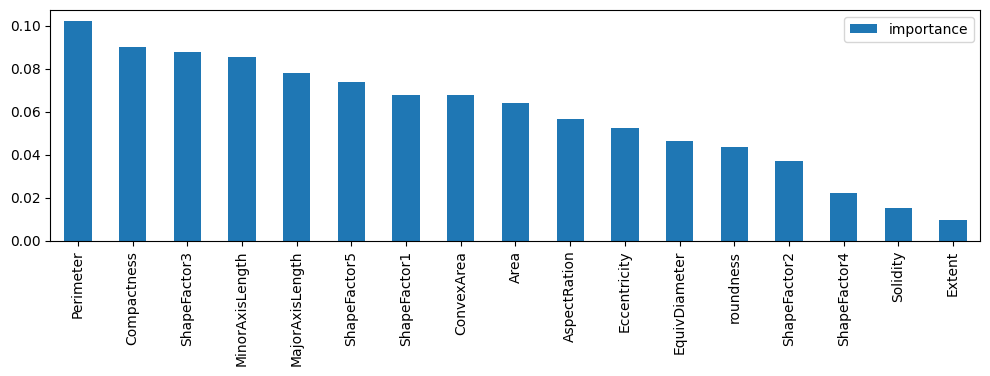

In [30]:
importances = forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 3))
feature_importances_sorted = feature_importances.sort_values('importance', ascending=False)
feature_importances_sorted.plot.bar(ax=ax)
ax.set_xticklabels(feature_importances_sorted['feature'])
importance_threshold = feature_importances.max()['importance']

Wynika z tego, że możemy nie brać pod uwagę niektórych kolumn, ale musimy sprawdzić jeszcze, jak dużo z nich usunąć

In [37]:
def evaluate_feature_importance(X, y, importance_threshold):
    forest = RandomForestClassifier(random_state=311)
    forest.fit(X, y)

    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': forest.feature_importances_}).sort_values('importance', ascending=True)

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X, y)

    results = []

    for i in range(len(feature_importances)):
        selected_features = feature_importances['feature'].iloc[i:]
        
        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        scores = cross_val_score(clf, X[selected_features], y, cv=5, scoring='accuracy')

        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std()
        })

    return pd.DataFrame(results)

In [82]:
results_with_1 = evaluate_feature_importance(X, y, importance_threshold)
results_with_2 = evaluate_feature_importance(X, y, importance_threshold-0.0001)

<Axes: xlabel='num_features'>

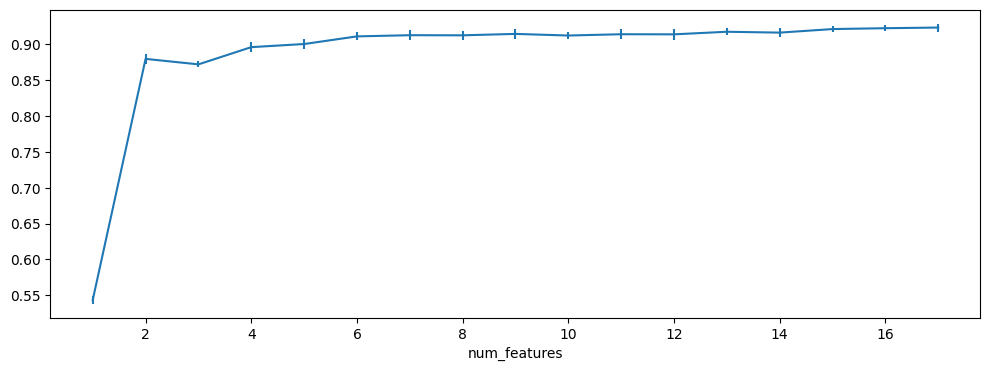

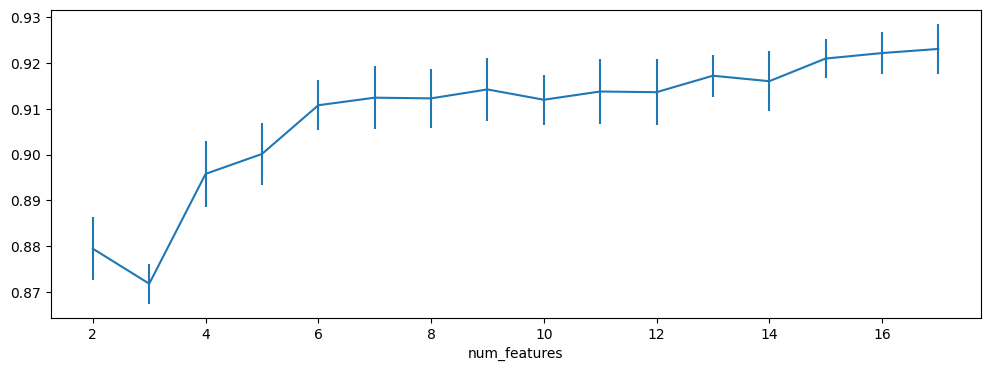

In [83]:
results_with_1.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
results_with_2.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)

Z wykresów wynika, że powinniśmy na pewno usunąć kolumny ShapeFactor2, AspectRatio i ShapeFactor3 ponieważ na wykresie widać, że gdy podczas sekwencyjnego usuwania kolumn, po usunięciu tych trzech accuracy modelu rośnie

Do tego możemy wziąć również pod uwagę kolumny których usuwanie podczas wykonania funkcji *evaluate_feature_importance* nie zmienia znacznie parametru accuracy modelu

# Tutaj coś

In [84]:
features_to_drop1 = ['ShapeFactor2', 'AspectRation', 'ShapeFactor3']
features_to_drop2 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1']
features_to_drop3 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']

In [ ]:
features_to_drop1 = ['ShapeFactor2', 'AspectRation', 'ShapeFactor3']
features_to_drop2 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1']
features_to_drop3 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']
mask1 = feature_importances['feature'].isin(features_to_drop1)
mask2 = feature_importances['feature'].isin(features_to_drop2)
mask3 = feature_importances['feature'].isin(features_to_drop3)
feature_names1 = feature_importances[~mask1]['feature']
feature_names2 = feature_importances[~mask2]['feature']
feature_names3 = feature_importances[~mask3]['feature']

clf = RandomForestClassifier(random_state=311)

pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
scores1 = cross_val_score(pipeline, X[feature_names1], y, cv=7, scoring='accuracy')
scores2 = cross_val_score(pipeline, X[feature_names2], y, cv=7, scoring='accuracy')
scores3 = cross_val_score(pipeline, X[feature_names3], y, cv=7, scoring='accuracy')

print("Scores\t\tMean\t\tStd")
print("-----\t\t----\t\t---")
print("scores\t\t{0}\t\t{1}".format(round(scores.mean(), 5), round(scores.std(), 5)))
print("scores1\t\t{0}\t\t{1}".format(round(scores1.mean(), 5), round(scores1.std(), 5)))
print("scores2\t\t{0}\t\t{1}".format(round(scores2.mean(), 5), round(scores2.std(), 5)))
print("scores3\t\t{0}\t\t{1}".format(round(scores3.mean(), 5), round(scores3.std(), 5)))


Scores		Mean		Std
-----		----		---
scores		0.92262		0.00485
scores1		0.92397		0.00318
scores2		0.92502		0.00631
scores3		0.91887		0.00804


Okazuje się że możemy usunąć bardzo dużo kolumn bez znacznej utraty accuracy lub usunąć pojedyncze kolumny co daje większą wartość accuracy niż wyjściowe dane. W dalszej części projektu będziemy starali się ustalić które podejście będzie najbardziej efektywne

# Preprocessing danych

In [85]:
def drop_columns(X, columns_to_drop):
    return X.drop(columns=columns_to_drop, axis=1)

In [86]:
def standarize(df, column):
    return RobustScaler().fit_transform(np.array(df[column]).reshape(-1, 1))

In [87]:
def replace_outliers(data):
    for column in data.columns:
        if data[column].dtype in ['int64', 'float64']:  # tylko dla kolumn numerycznych
            Q1 = data.groupby('Class')[column].quantile(0.25)
            Q3 = data.groupby('Class')[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            mean = data.groupby('Class')[column].mean()
            for class_name in data['Class'].unique():
                data.loc[(data['Class'] == class_name) & (data[column] < lower_bound[class_name]), column] = mean[class_name]
                data.loc[(data['Class'] == class_name) & (data[column] > upper_bound[class_name]), column] = mean[class_name]
    return data

In [88]:
# To na razie jeszcze nie działa ale ma potencjał

def test_models_with_dropped_columns(df, models, columns_to_drop, to_standarize=False, replacing_outliers=False):
    """
    Test multiple models with different sets of dropped columns.

    Parameters:
    X (DataFrame): The input data
    y (Series or array-like): The target values
    models (list): A list of tuples, where each tuple contains a string (the model name) and a scikit-learn estimator object (the model)
    columns_to_drop (list): A list of lists, where each inner list contains the names of the columns to be dropped

    Returns:
    DataFrame: A DataFrame containing the mean and standard deviation of the accuracy for each combination of model and dropped columns
    """
    results = []
    if replacing_outliers:
        df = replace_outliers(df)
    X = df.drop(columns=['Class'])
    y = df['Class']
    for model_name, model in models:
        for columns in columns_to_drop:
            X_transformed = drop_columns(X, columns)
            if to_standarize:
                for col in X_transformed.columns:
                    X_transformed[col] = standarize(X_transformed, col)
                
            scores = cross_val_score(model, X_transformed, y, cv=5, scoring='accuracy')
            results.append({
                'model' : model_name,
                'columns_dropped' : columns,
                'mean_accuracy' : scores.mean(),
                'std_accuracy' : scores.std()
            })

    return pd.DataFrame(results)

In [ ]:
# potestujemy sobie teraz te wybrane kolumny razem ze skalowaniem i bez na gołych modelach: SVC, XGBoost, RandomForest, AdaBoost, LGBM

### Utworzenie wstępnych modeli do testowania wyborów kolumn oraz ich skalowania

In [89]:
models = [('SVC', SVC(random_state=311)), 
          # ('XGBoost', XGBClassifier(random_state=311)), 
          ('RandomForest', RandomForestClassifier(random_state=311)), 
          ('AdaBoost', AdaBoostClassifier(random_state=311)), 
          ('LGBM', LGBMClassifier(random_state=311))
]

columns_to_drop = [
    ['ShapeFactor2', 'AspectRation', 'ShapeFactor3'],
    ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1'],
    ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']
]


In [90]:
results_without_standarization = test_models_with_dropped_columns(df, models, columns_to_drop)
results_with_standarization = test_models_with_dropped_columns(df, models, columns_to_drop, to_standarize=True)

In [91]:
results_without_standarization

,model,columns_dropped,mean_accuracy,std_accuracy
0,SVC,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.634977,0.011289
1,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.858431,0.008980
2,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.864579,0.007896
3,RandomForest,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.924416,0.005444
4,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.922618,0.007175
5,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.919918,0.005576
6,AdaBoost,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.448654,0.229627
7,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
8,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
9,LGBM,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.927716,0.007357


In [35]:
results_with_standarization_and_replacing_outliers = test_models_with_dropped_columns(df, models, columns_to_drop, to_standarize=True, replacing_outliers=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 14
[LightGBM] [Info] Start training from score -2.333814
[LightGBM] [Info] Start training from score -3.258847
[LightGBM] [Info] Start training from score -2.121952
[LightGBM] [Info] Start training from score -1.344798
[LightGBM] [Info] Start training from score -1.953815
[LightGBM] [Info] Start training from score -1.904773
[LightGBM] [Info] Start training from score -1.641634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [31]:
results_without_standarization

,model,columns_dropped,mean_accuracy,std_accuracy
0,SVC,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.634977,0.011289
1,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.858431,0.008980
2,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.864579,0.007896
3,RandomForest,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.924416,0.005444
4,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.922618,0.007175
5,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.919918,0.005576
6,AdaBoost,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.448654,0.229627
7,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
8,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
9,LGBM,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.927716,0.007357


In [92]:
results_with_standarization

,model,columns_dropped,mean_accuracy,std_accuracy
0,SVC,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.929067,0.009038
1,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.927867,0.009036
2,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.925167,0.009171
3,RandomForest,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.924716,0.005174
4,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.923217,0.006243
5,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.919768,0.005364
6,AdaBoost,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.448654,0.229627
7,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
8,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.672916,0.013338
9,LGBM,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.926816,0.008533


In [36]:
results_with_standarization_and_replacing_outliers

,model,columns_dropped,mean_accuracy,std_accuracy
0,SVC,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.956059,0.003161
1,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.952311,0.004650
2,SVC,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.948712,0.006147
3,RandomForest,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.954409,0.005678
4,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.953959,0.004756
5,RandomForest,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.945711,0.004384
6,AdaBoost,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.551574,0.088525
7,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.645943,0.077865
8,AdaBoost,"[roundness, EquivDiameter, Eccentricity, Aspec...",0.650584,0.072786
9,LGBM,"[ShapeFactor2, AspectRation, ShapeFactor3]",0.956959,0.004095


Standaryzacja kolumn pomogła uzyskać zdecydowanie lepsze wyniki dla modelu SVC, reszta raczej bez zmian